In [1]:
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [2]:
#  Load CESM model output as input for our model
cesm_data_path = "/data/keeling/a/mailes2/a/CESM_DATA/test_compB/outputdata/atm/hist/"
cesm_input = xr.open_dataset(cesm_data_path + "test_compB.cam.h0.0001-12.nc")
cesm_input

<xarray.Dataset>
Dimensions:       (lev: 26, ilev: 27, time: 1, lat: 46, lon: 72, slat: 45,
                   slon: 72, nbnd: 2)
Coordinates:
  * lev           (lev) float64 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * ilev          (ilev) float64 2.194 4.895 9.882 18.05 ... 956.0 985.1 1e+03
  * time          (time) object 0002-01-01 00:00:00
  * lat           (lat) float64 -90.0 -86.0 -82.0 -78.0 ... 78.0 82.0 86.0 90.0
  * lon           (lon) float64 0.0 5.0 10.0 15.0 ... 340.0 345.0 350.0 355.0
  * slat          (slat) float64 -88.0 -84.0 -80.0 -76.0 ... 76.0 80.0 84.0 88.0
  * slon          (slon) float64 -2.5 2.5 7.5 12.5 ... 337.5 342.5 347.5 352.5
Dimensions without coordinates: nbnd
Data variables: (12/114)
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    P0            float64 ...
    date          (time) int32 ...
    ...            ...
    VD01          (time, lev, lat, lon) float32 ...
    VQ            (time, lev, lat, lon) float32 ...
    VT            (time, lev, lat, lon) float32 ...
    VU            (time, lev, lat, lon) float32 ...
    VV            (time, lev, lat, lon) float32 ...
    Z3            (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             test_compB
    title:            UNSET
    logname:          mailes2
    host:             keeling-j01
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /data/keeling/a/mailes2/a/CESM_DATA/CESM_INPUT_DATA/atm...
    topography_file:  /data/keeling/a/mailes2/a/CESM_DATA/CESM_INPUT_DATA/atm...

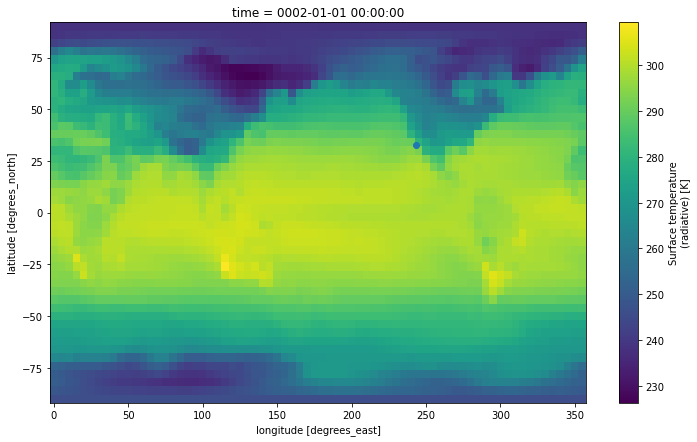

In [11]:
plt.rcParams['figure.figsize'] = [12, 7]
cesm_input.TS.isel(time=0).plot()
plt.plot(243,32.7,marker='o')

In [4]:
cesm_Q = cesm_input.Q.sel(lat=32.7, method='nearest').sel(lon=243, method='nearest').isel(time=0)
cesm_Q

<xarray.DataArray 'Q' (lev: 26)>
array([1.424427e-06, 1.398359e-06, 1.389966e-06, 1.391455e-06, 1.414760e-06,
       1.471076e-06, 1.522436e-06, 1.538896e-06, 1.604881e-06, 1.819955e-06,
       2.674208e-06, 6.063565e-06, 1.165738e-05, 2.091945e-05, 4.120742e-05,
       8.605083e-05, 1.802648e-04, 3.404450e-04, 6.179888e-04, 1.031884e-03,
       1.470361e-03, 2.117140e-03, 3.026316e-03, 4.478039e-03, 5.135286e-03,
       5.507403e-03], dtype=float32)
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
    time     object 0002-01-01 00:00:00
    lat      float64 34.0
    lon      float64 245.0
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

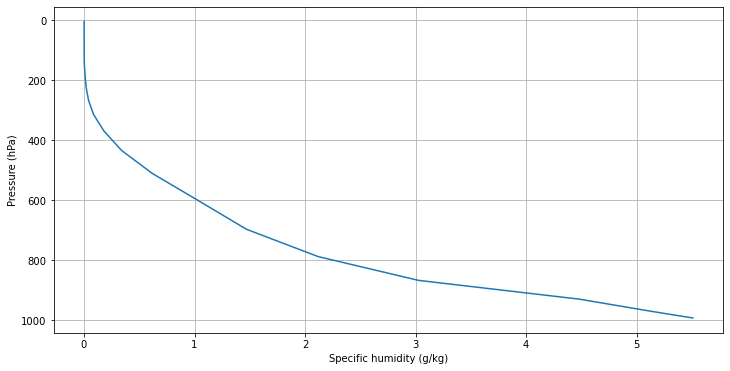

In [5]:
plt.rcParams["figure.figsize"] = (12,6)

#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air

plt.plot(cesm_Q*1000., cesm_Q.lev)
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('Specific humidity (g/kg)')
plt.grid()
plt.show()

In [8]:
def model_setup(Q):
    """
    This is the model setup for both RRTMG_LW and RRTMG_SW
    
    Input:
        Q - (array) The specific humidity profile
    Output:
        radmodel_LW - Longwave radiative model
        radmodel_SW - Shortwave radiative model
        
    """
    # Setting up the atmospheric temperatures within the column
    mystate = climlab.column_state(lev=Q.lev, # These are the elevation levels. We'll be using CESM's elev. levels.
                               water_depth=2.5 
                              )
    
    # Setting up the longwave RRTMG
    radmodel_LW = climlab.radiation.RRTMG_LW(name='Shortwave Radiation', # Model name
                              state=mystate,                         # Initial temperature conditions
                              specific_humidity=Q.values,            # Water vapor - coming from the CESM output
                              albedo = 0.25                          # Surface shortwave albedo
                                            )
    # Running the model
    radmodel_LW.compute_diagnostics()

    # Setting up the shortwave RRTMG
    radmodel_SW = climlab.radiation.RRTMG_SW(name='Longwave Radiation', # Model name
                              state=mystate,                        # Initial temperature conditions
                              specific_humidity=Q.values,           # Water vapor - coming from the CESM output
                              albedo = 0.25                         # Surface shortwave albedo
                             )
    # Running the model
    radmodel_SW.compute_diagnostics()
    
    return radmodel_LW, radmodel_SW

In [9]:
rad_LW_cesm, rad_SW_cesm = model_setup(cesm_Q)

In [ ]:
def plotting()